<a href="https://colab.research.google.com/github/TanoMDG/Procesamiento-del-habla/blob/main/Gallo%2CMarcos_Desaf%C3%ADo_final_Martin_FIerro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **TÍTULO**: Desafío Obligatorio Final

## **TEMA**: Generador de Texto con Redes Recurrentes: Estudio Comparativo entre RNN, GRU y LSTM utilizando "El Gaucho Martín Fierro"
## **Materia**: Procesamiento del Habla
### **Alumno**: Marcos Gallo
### **Profesora**: Ing. Ana Diedrich


### **Objetivo**:

Crear un modelo generador de texto basado en el poema "El Gaucho Martín Fierro"; usando diferentes arquitecturas de redes recurrentes (RNN, GRU y LSTM) para aprender patrones del texto y generar contenido coherente. Comparando luego la capacidad de cada tipo de red recurrente para modelar y generar texto y evaluando el impacto de los hiperparámetros en el rendimiento de cada modelo.



### **Desarrollo**:

Para la primer parte del trabajo fui tomando parte del código que se había utilizado en el desafío anterior, con algunas modificaciones que realicé, adjuntando la explicación correspondiente.

#### Instalaciones e Importación de las librerías necesarias

In [ ]:
!pip install pdfplumber
!pip install spacy
!python -m spacy download es_core_news_sm
import requests
import os
import pdfplumber
import re
import spacy
from collections import Counter
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, GRU, LSTM, Embedding, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import SimpleRNN, GRU, LSTM, Dense


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 44.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


#### DESCARGA DEL ARCHIVO DESDE LA WEB

In [ ]:
#creo la variable url
url = "https://www.argentina.gob.ar/sites/default/files/hernandez_jose_-_el_gaucho_martin_fierro.pdf"

#hago el get y guardo la respuesta
response = requests.get(url)

#si la respuesta es ok, abro el archivo, descargo los datos y con eso escribo el archivo
if response.status_code == 200:
  file_name = "el_gaucho_martin_fierro.pdf"
  with open(file_name, "wb") as file:
    file.write(response.content)
#imprimo el peso para verificar que se haya descargado correctamente
  file_size = os.path.getsize(file_name)
  print(f"PDF descargado exitosamente, tamaño del archivo: {file_size} bytes")
else:
#veo cual es el código de estado del response si la respuesta no fue 200
  print(f"Error al descargar el PDF. Código de estado: {response.status_code}")


PDF descargado exitosamente, tamaño del archivo: 513796 bytes


### Procesar el archivo PDF:
Extrayendo solo el texto relevante. Aquí hice una modificación en la función de extracción del texto, especificando que comience el procesamiento en la página 3 y no desde la 0, ya que recién en esa página inicia el texto relevante.

Agregué además la función "limpiar_referencias" para eliminar las referencias de página porque me generaron errores en el entrenamiento de los modelos y la generación de texto.

In [ ]:
# Función para determinar si una página debe procesarse
def pagina_a_procesar(texto_pagina):
    # Palabras clave para omitir ciertas secciones
    palabras_omitir = ['Índice', 'Prólogo', 'Anexo', 'Imágenes', 'Agradecimientos', 'Dedicatoria', 'http']

    for palabra in palabras_omitir:
        if palabra.lower() in texto_pagina.lower():
            return False
    return True

# Función para limpiar referencias como "Página 1", "Página 2", etc.
def limpiar_referencias(texto):
    # Eliminar cualquier texto que siga el patrón "Página <número>"
    return re.sub(r'\bPágina\s+\d+\b', '', texto)

# Función para extraer el texto relevante del PDF
def extraer_texto(filename):
    texto_relevante = ''

    with pdfplumber.open(filename) as pdf:
        pagina_inicio = 3
        pagina_fin = len(pdf.pages)

        for pagina_numero in range(pagina_inicio, pagina_fin):
            pagina = pdf.pages[pagina_numero]
            texto_pagina = pagina.extract_text()

            if texto_pagina and pagina_a_procesar(texto_pagina):
                # Limpiar referencias de página antes de agregar el texto
                texto_limpio = limpiar_referencias(texto_pagina)
                texto_relevante += texto_limpio + '\n'

    return texto_relevante

# Reemplaza 'file_name' con el nombre de tu archivo PDF
texto = extraer_texto(file_name)

# Mostrar el texto extraído
print("Texto relevante extraído:")
print(texto)



Texto relevante extraído:
El Gaucho Martín Fierro
I
Aquí me pongo a cantar
al compás de la vigüela,
que el hombre que lo desvela
una pena estrordinaria,
como la ave solitaria
con el cantar se consuela.
Pido a los santos del cielo
que ayuden mi pensamiento:
les pido en este momento
que voy a cantar mi historia
me refresquen la memoria
y aclaren mi entendimiento.
Vengan santos milagrosos,
vengan todos en mi ayuda,
que la lengua se me añuda
y se me turba la vista;
pido a mi Dios que me asista
en una ocasión tan ruda.
Yo he visto muchos cantores,
con famas bien otenidas
y que después de alquiridas
no las quieren sustentar:
parece que sin largar
se cansaron en partidas.
Mas ande otro criollo pasa
Martín Fierro ha de pasar;
nada lo hace recular,
ni las fantasmas lo espantan,
y dende que todos cantan
yo también quiero cantar.
Cantando me he de morir,
cantando me han de enterrar,
y cantando he de llegar
al pie del Eterno Padre;
dende el vientre de mi madre
vine a este mundo a cantar.
Que no se


### Normalización:

Agregué la conversión de todo el texto a minúsculas que me faltaba.
Elimino carácteres extraños que no aporten al modelo (por ejemplo, símbolos o espacios repetidos).
Conserva los saltos de línea para respetar la estructura en estrofas.



In [ ]:
import re

def normalizar_texto(texto):
    texto = texto.lower()
    texto = re.sub(r'[^a-záéíóúüñ\s\n]', '', texto)  # Conserva letras, espacios, saltos de línea
    return texto

texto_normalizado = normalizar_texto(texto)
print("Texto normalizado:")
print(texto_normalizado[:500])  # Muestra los primeros 500 caracteres para verificar


Texto normalizado:
el gaucho martín fierro
i
aquí me pongo a cantar
al compás de la vigüela
que el hombre que lo desvela
una pena estrordinaria
como la ave solitaria
con el cantar se consuela
pido a los santos del cielo
que ayuden mi pensamiento
les pido en este momento
que voy a cantar mi historia
me refresquen la memoria
y aclaren mi entendimiento
vengan santos milagrosos
vengan todos en mi ayuda
que la lengua se me añuda
y se me turba la vista
pido a mi dios que me asista
en una ocasión tan ruda
yo he visto muc


### Tokenización:
 Pruebo trabajar con caracteres como unidades de entrada. Para un poema como el Martín Fierro, usar caracteres podría ser una buena opción.

Vocabulario: Extrae los caracteres únicos y asigna un índice a cada uno

In [ ]:
chars = sorted(list(set(texto_normalizado))) # Crea un conjunto único de caracteres presentes en el texto, ordena alfabéticamente y los convierte en una lista.
char_to_idx = {char: idx for idx, char in enumerate(chars)} # Crea un diccionario que asocia cada carácter único con un índice.
idx_to_char = {idx: char for idx, char in enumerate(chars)} # Crea un diccionario inverso que asocia cada índice con su carácter correspondiente.
vocab_size = len(chars)
print(f"Vocabulario: {chars}")
print(f"Tamaño del vocabulario: {vocab_size}")


Vocabulario: ['\n', ' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'x', 'y', 'z', 'á', 'é', 'í', 'ñ', 'ó', 'ú', 'ü']
Tamaño del vocabulario: 33


### Crear las secuencias para el modelo:
Dividiendo el texto en secuencias de longitud fija y generando los pares entrada-salida:

Entrada: Una secuencia de caracteres.

Salida: El carácter que sigue a esa secuencia.

Usar secuencias como entrada y su carácter posterior como objetivo. Esto es útil en tareas de autocompletado y generación de texto.

In [ ]:
seq_length = 50  # Longitud de las secuencias
step = 1  # Pasos entre cada secuencia
X = []
y = []

for i in range(0, len(texto_normalizado) - seq_length, step):
    X.append(texto_normalizado[i:i + seq_length])
    y.append(texto_normalizado[i + seq_length])

print(f"Total de secuencias: {len(X)}")


Total de secuencias: 58183


### Convertir estas secuencias a matrices numéricas usando el vocabulario:

El proximo código convierte las secuencias de texto "X" y los objetivos "y" en representaciones numéricas mediante codificación one-hot.Cada carácter se representa como un vector con un único valor activo (1) y el resto en 0. Posteriormente, divide los datos en conjuntos de entrenamiento y prueba.

In [ ]:
#

# Convertir las secuencias X y y a matrices numéricas
X_num = np.zeros((len(X), seq_length, vocab_size), dtype=np.bool_)
y_num = np.zeros((len(y), vocab_size), dtype=np.bool_)

for i, seq in enumerate(X):
    for t, char in enumerate(seq):
        X_num[i, t, char_to_idx[char]] = 1
    y_num[i, char_to_idx[y[i]]] = 1

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_num, y_num, test_size=0.2, random_state=42)


#

### Entrenar los modelos LSTM, GRU y RNN

Define el modelo e inicia el entrenamiento.

defino una función que construye un modelo secuencial en Keras con diferentes tipos de capas recurrentes (RNN, GRU o LSTM).


In [ ]:

def construir_modelo(tipo='LSTM', input_shape=(50, 40), unidades=128, vocab_size=40):
    """
    Construye un modelo secuencial basado en el tipo especificado.

    tipo: 'RNN', 'GRU' o 'LSTM'
    input_shape: dimensión de entrada (longitud de secuencia, tamaño del vocabulario)
    unidades: número de neuronas en la capa recurrente
    vocab_size: tamaño del vocabulario (número de clases de salida)
    """
    modelo = Sequential()

    if tipo == 'RNN':
        modelo.add(SimpleRNN(unidades, input_shape=input_shape))
    elif tipo == 'GRU':
        modelo.add(GRU(unidades, input_shape=input_shape))
    elif tipo == 'LSTM':
        modelo.add(LSTM(unidades, input_shape=input_shape))
    else:
        raise ValueError("Tipo no válido. Usa 'RNN', 'GRU' o 'LSTM'.")

    modelo.add(Dense(vocab_size, activation='softmax'))
    modelo.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return modelo



### Entrenamiento:

In [ ]:
# Construir modelos RNN, GRU y LSTM
modelo_rnn = construir_modelo(tipo='RNN', input_shape=(seq_length, vocab_size), unidades=64, vocab_size=vocab_size)
modelo_gru = construir_modelo(tipo='GRU', input_shape=(seq_length, vocab_size), unidades=64, vocab_size=vocab_size)
modelo_lstm = construir_modelo(tipo='LSTM', input_shape=(seq_length, vocab_size), unidades=64, vocab_size=vocab_size)

# Entrenar el modelo RNN
print("Entrenando modelo RNN...")
historia_rnn = modelo_rnn.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=64)

# Entrenar el modelo GRU
print("Entrenando modelo GRU...")
historia_gru = modelo_gru.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=64)

# Entrenar el modelo LSTM
print("Entrenando modelo LSTM...")
historia_lstm = modelo_lstm.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=64)



Entrenando modelo RNN...
Epoch 1/10
728/728 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.1932 - loss: 2.8264 - val_accuracy: 0.2874 - val_loss: 2.3015
Epoch 2/10
728/728 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.3143 - loss: 2.2221 - val_accuracy: 0.3426 - val_loss: 2.1252
Epoch 3/10
728/728 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.3559 - loss: 2.0784 - val_accuracy: 0.3591 - val_loss: 2.0492
Epoch 4/10
728/728 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.3667 - loss: 2.0215 - val_accuracy: 0.3663 - val_loss: 2.0162
Epoch 5/10
728/728 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - accuracy: 0.3781 - loss: 1.9777 - val_accuracy: 0.3736 - val_loss: 1.9843
Epoch 6/10
728/728 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - accuracy: 0.3882 - loss: 1.9373 - val_accuracy: 0.3826 - val_loss: 1.9601
Epoch 7/10
728/728 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.3957 - loss: 1.9118 - val_accuracy: 0.3893 - val_loss: 1.9392
Epoch 8/10
728/728 ━━━━━━━━━━━━━━━━━━━━ 22s 18ms/step - accuracy: 

### Gráfico de las métricas evaluadas en entrenamiento y validación para cada modelo

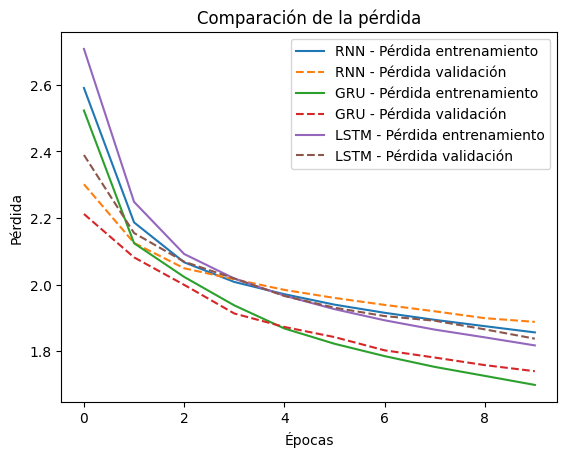

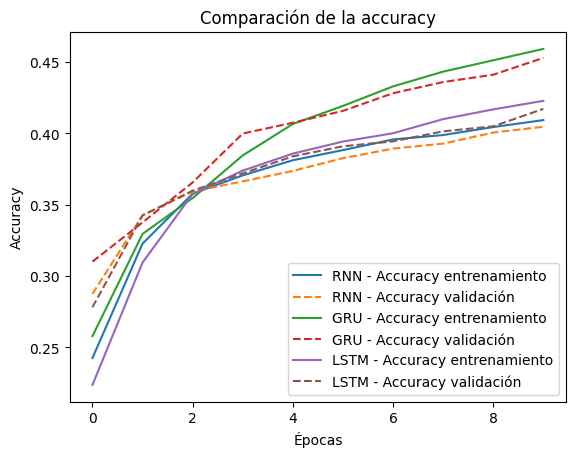

In [ ]:
import matplotlib.pyplot as plt
# Graficar pérdidas
plt.plot(historia_rnn.history['loss'], label='RNN - Pérdida entrenamiento')
plt.plot(historia_rnn.history['val_loss'], label='RNN - Pérdida validación', linestyle='--')

plt.plot(historia_gru.history['loss'], label='GRU - Pérdida entrenamiento')
plt.plot(historia_gru.history['val_loss'], label='GRU - Pérdida validación', linestyle='--')

plt.plot(historia_lstm.history['loss'], label='LSTM - Pérdida entrenamiento')
plt.plot(historia_lstm.history['val_loss'], label='LSTM - Pérdida validación', linestyle='--')

plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.title('Comparación de la pérdida')
plt.show()

# Graficar accuracy
plt.plot(historia_rnn.history['accuracy'], label='RNN - Accuracy entrenamiento')
plt.plot(historia_rnn.history['val_accuracy'], label='RNN - Accuracy validación', linestyle='--')

plt.plot(historia_gru.history['accuracy'], label='GRU - Accuracy entrenamiento')
plt.plot(historia_gru.history['val_accuracy'], label='GRU - Accuracy validación', linestyle='--')

plt.plot(historia_lstm.history['accuracy'], label='LSTM - Accuracy entrenamiento')
plt.plot(historia_lstm.history['val_accuracy'], label='LSTM - Accuracy validación', linestyle='--')

plt.xlabel('Épocas')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Comparación de la accuracy')
plt.show()



Análisis de los graficos:                                 
1. Modelo RNN

- Comienza con una precisión (accuracy) de 19.32% y una pérdida (loss) de 2.8264.
- Al final de las 10 épocas, alcanza una precisión de entrenamiento del 40.92% y una pérdida de 1.8581.
- La precisión en el conjunto de validación mejora de 29.64% a 41.71%, mientras que la pérdida disminuye de 2.3015 a 1.8377.
- El modelo muestra una mejora constante, pero el ritmo de progreso es limitado.
- La precisión final es baja, lo que indica que el modelo tiene dificultades para capturar dependencias complejas en los datos.


2. Modelo GRU

- Comienza con una precisión inicial de 20.55% y una pérdida de 2.8121.
- Después de 10 épocas, alcanza una precisión de entrenamiento de 45.89% y una pérdida de 1.7029.
- La precisión de validación mejora de 31.00% a 49.29%, y la pérdida de validación disminuye hasta 1.7400.
- GRU aprende más rápidamente y alcanza mejores métricas en comparación con RNN.
- Su capacidad para manejar dependencias a largo plazo mejora la precisión.
- El aumento de tiempo por época (alrededor de 40 segundos) refleja el mayor costo computacional.


3. Modelo LSTM

- Comienza con una precisión inicial de 17.26% y una pérdida de 2.9260.
- Después de 10 épocas, alcanza una precisión de entrenamiento de 41.07% y una pérdida de 1.8581.
- La precisión de validación mejora de 27.81% a 40.12%, y la pérdida de validación disminuye de 2.3894 a 1.8807.
- LSTM muestra un rendimiento inicial similar al de RNN pero con una mejora constante a lo largo de las épocas.
- La precisión de validación es comparable a la de RNN, pero con una pérdida de validación ligeramente mejor al final.
- Es casi igual de eficiente que GRU en términos de tiempo por época (~35 segundos), su rendimiento no alcanza el nivel de GRU.


###  Generar texto
Defino una función para generar texto:

In [ ]:
def generar_texto(model, seed, length, char_to_idx, idx_to_char):
    resultado = seed
    for _ in range(length):
        x_pred = np.zeros((1, len(seed), vocab_size))
        for t, char in enumerate(seed):
            x_pred[0, t, char_to_idx[char]] = 1

        preds = model.predict(x_pred, verbose=0)[0]
        next_idx = np.argmax(preds)
        next_char = idx_to_char[next_idx]

        resultado += next_char
        seed = seed[1:] + next_char
    return resultado


Prueba de  generar texto con una semilla inicial:

In [ ]:
seed = "viene clareando el dia y"  # Semilla inicial

print("Texto generado con RNN:")
print(generar_texto(modelo_rnn, seed.lower(), 100, char_to_idx, idx_to_char))

print("\nTexto generado con GRU:")
print(generar_texto(modelo_gru, seed.lower(), 100, char_to_idx, idx_to_char))

print("\nTexto generado con LSTM:")
print(generar_texto(modelo_lstm, seed.lower(), 100, char_to_idx, idx_to_char))



Texto generado con RNN:
viene clareando el dia yo
y la male de para la caro
y la maler al vida
y la maler al vida
y la maler al vida
y la maler al v

Texto generado con GRU:
viene clareando el dia y el paro
y a la chin de parar
no hacer en la chinto
y la manda a la chinto
y la manda a la chinto
y 

Texto generado con LSTM:
viene clareando el dia yo
y al mala a la me el palando
y al mala a la me el palando
y al mala a la me el palando
y al mala a


### Análisis del texto generado:

Lo que se nota es que ningún modelo generó un texto coherente. El que apenas logró mas variedad de palabras es el modelo GRU,  pero sin sentido. En los otros dos modelos además de no tener coherencia en la redacción, se ve que aumenta la repetición.

Otra cosa que se nota es la aparición de palabras sin significado, esto seguramente debido a la división del texto en caracteres y no en palabras (un caracter no tiene significado propio y al modelo le cuesta mas aprenderlo)

Falta ver con el ajuste de parámetros si se logra un mejor desempeño.

-----
----

### PRUEBO AHORA DIVIDIR EL TEXTO EN PALABRAS Y NO EN CARACTERES COMO FUE EL PROCESO ANTERIOR

### Tokenización del texto

Convierto el texto en números para que el modelo lo entienda. Utilizo el módulo Tokenizer de Keras para convertir el texto en secuencias de tokens y generar secuencias n-gram para modelar datos textuales.

In [ ]:
# Cargar el modelo en español
nlp = spacy.load('es_core_news_sm')

# Procesar el texto extraído con Spacy
doc = nlp(texto)

def crear_corpus(texto):
    # Reemplazar puntos finales y signos de exclamación por doble espacio
    texto_modificado = re.sub(r'([.!])', r'\1  ', texto)

    # Dividir el texto en estrofas usando doble espacio como delimitador
    estrofas = texto_modificado.split('  ')

    # Limpiar estrofas vacías y eliminar espacios adicionales
    estrofas = [estrofa.strip() for estrofa in estrofas if estrofa.strip()]

    return estrofas

# La variable `texto` ya está definida
# Crear el corpus de documentos
corpus_documentos = crear_corpus(texto)

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus_documentos)
total_words = len(tokenizer.word_index) + 1  # Total de palabras únicas en el vocabulario

# Crear secuencias de palabras
input_sequences = []
for line in corpus_documentos:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i + 1]
        input_sequences.append(n_gram_sequence)


In [ ]:
print(input_sequences)  # Verifica el contenido de input_sequences



[[3, 29], [3, 29, 581], [3, 29, 581, 148], [3, 29, 581, 148, 1014], [3, 29, 581, 148, 1014, 133], [3, 29, 581, 148, 1014, 133, 8], [3, 29, 581, 148, 1014, 133, 8, 582], [3, 29, 581, 148, 1014, 133, 8, 582, 6], [3, 29, 581, 148, 1014, 133, 8, 582, 6, 89], [3, 29, 581, 148, 1014, 133, 8, 582, 6, 89, 14], [3, 29, 581, 148, 1014, 133, 8, 582, 6, 89, 14, 1015], [3, 29, 581, 148, 1014, 133, 8, 582, 6, 89, 14, 1015, 5], [3, 29, 581, 148, 1014, 133, 8, 582, 6, 89, 14, 1015, 5, 4], [3, 29, 581, 148, 1014, 133, 8, 582, 6, 89, 14, 1015, 5, 4, 1016], [3, 29, 581, 148, 1014, 133, 8, 582, 6, 89, 14, 1015, 5, 4, 1016, 2], [3, 29, 581, 148, 1014, 133, 8, 582, 6, 89, 14, 1015, 5, 4, 1016, 2, 3], [3, 29, 581, 148, 1014, 133, 8, 582, 6, 89, 14, 1015, 5, 4, 1016, 2, 3, 46], [3, 29, 581, 148, 1014, 133, 8, 582, 6, 89, 14, 1015, 5, 4, 1016, 2, 3, 46, 2], [3, 29, 581, 148, 1014, 133, 8, 582, 6, 89, 14, 1015, 5, 4, 1016, 2, 3, 46, 2, 13], [3, 29, 581, 148, 1014, 133, 8, 582, 6, 89, 14, 1015, 5, 4, 1016, 2, 3,

### Pad sequences y etiquetas

Se logra que todas las secuencias tengan el mismo largo y crear las etiquetas de salida: preprocesa las secuencias generadas anteriormente para adaptarlas a un formato adecuado para entrenar un modelo de lenguaje.

Luego de este paso, las secuencias están listas para entrenar un modelo de lenguaje con las siguientes características:

x: Conjunto de secuencias de entrada.

y: Etiquetas categóricas que representan la siguiente palabra en la secuencia.

In [ ]:
max_sequence_len = max([len(seq) for seq in input_sequences])
input_sequences = tf.keras.preprocessing.sequence.pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre')

# Dividir entrada y etiquetas
#Para x, Selecciona todas las columnas excepto la última como entrada (x).Representa la secuencia que el modelo usará para predecir la siguiente palabra.
#Para y, Selecciona la última columna como etiqueta (y).Representa la palabra que el modelo debe predecir.
x, y = input_sequences[:, :-1], input_sequences[:, -1]
y = to_categorical(y, num_classes=total_words) # Convierte las etiquetas (y) en una representación one-hot.


In [ ]:
max_sequence_len

73

### Función de Construcción del Modelo

Esta función genera un modelo configurable basado en el tipo de red recurrente: construye y compila un modelo de red neuronal secuencial utilizando una capa de embedding y un tipo de red recurrente (RNN, GRU o LSTM)

In [ ]:
def build_model(rnn_type, input_length, vocab_size, embedding_dim=64, units=128):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=input_length))

    if rnn_type == 'RNN':
        model.add(SimpleRNN(units, return_sequences=False))
    elif rnn_type == 'GRU':
        model.add(GRU(units, return_sequences=False))
    elif rnn_type == 'LSTM':
        model.add(LSTM(units, return_sequences=False))

    model.add(Dropout(0.2))
    model.add(Dense(vocab_size, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


In [ ]:
from sklearn.model_selection import train_test_split

# Dividir los datos en entrenamiento y prueba (80% entrenamiento, 20% prueba)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=11)

# Entrenar los modelos
models = {}
histories = {}
rnn_types = ['RNN', 'GRU', 'LSTM']

for rnn_type in rnn_types:
    print(f"\nEntrenando modelo {rnn_type}...")
    model = build_model(rnn_type, input_length=max_sequence_len - 1, vocab_size=total_words)
    history = model.fit(x_train, y_train, epochs=15, verbose=1, validation_data=(x_test, y_test))

    models[rnn_type] = model
    histories[rnn_type] = history



Entrenando modelo RNN...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/15
271/271 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - accuracy: 0.0320 - loss: 6.9930 - val_accuracy: 0.0346 - val_loss: 6.5208
Epoch 2/15
271/271 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.0419 - loss: 6.1599 - val_accuracy: 0.0558 - val_loss: 6.6472
Epoch 3/15
271/271 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - accuracy: 0.0480 - loss: 5.9480 - val_accuracy: 0.0498 - val_loss: 6.6921
Epoch 4/15
271/271 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - accuracy: 0.0621 - loss: 5.6461 - val_accuracy: 0.0466 - val_loss: 6.8393
Epoch 5/15
271/271 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - accuracy: 0.0737 - loss: 5.3193 - val_accuracy: 0.0526 - val_loss: 6.9260
Epoch 6/15
271/271 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - accuracy: 0.0913 - loss: 5.0067 - val_accuracy: 0.0503 - val_loss: 7.0294
Epoch 7/15
271/271 ━━━━━━━━━━━━━━━━━━━━ 18s 34ms/step - accuracy: 0.1148 - loss: 4.6872 - val_accuracy: 0.0480 - val_loss: 7.1785
Epoch 8/15
271/271 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - accuracy: 0.1565 - loss: 4.3622 - v

#### Evaluación del Modelo

Grafico la pérdida y precisión de cada modelo (en los datos de entrenamiento y en los de validación)

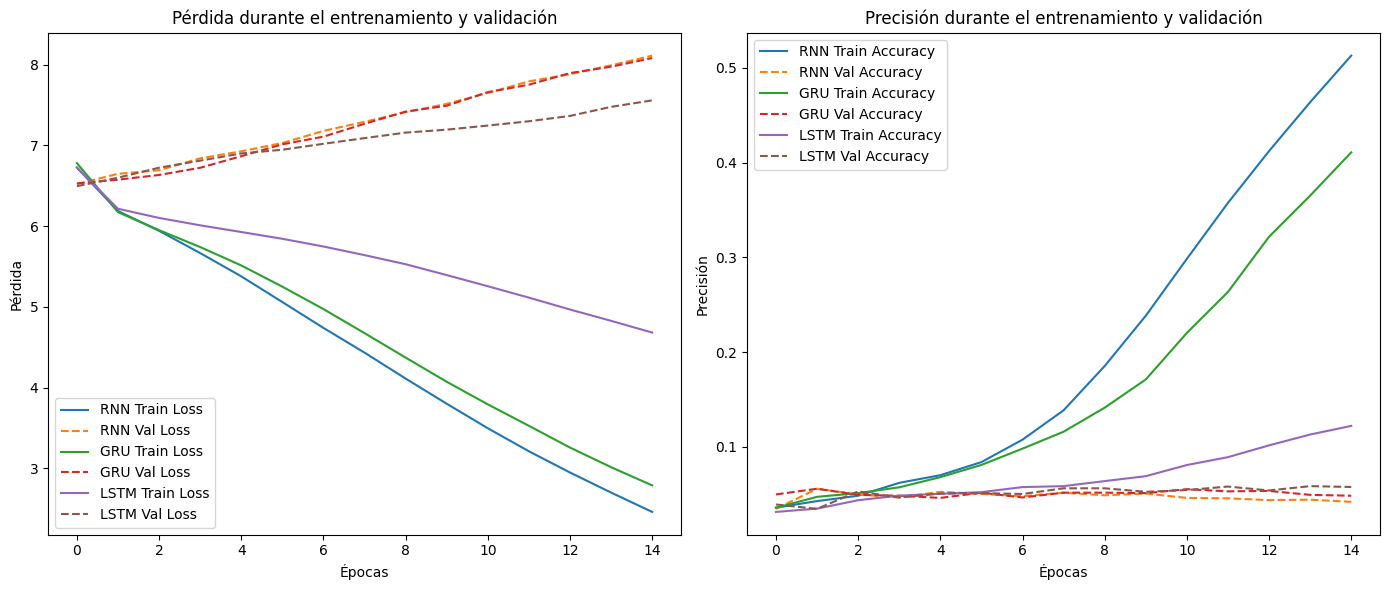

In [ ]:
import matplotlib.pyplot as plt

# Crear una figura con 2 subgráficos (uno para pérdida y otro para precisión)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Graficar la pérdida de entrenamiento y validación para cada modelo
for rnn_type in rnn_types:
    ax1.plot(histories[rnn_type].history['loss'], label=f'{rnn_type} Train Loss')
    ax1.plot(histories[rnn_type].history['val_loss'], label=f'{rnn_type} Val Loss', linestyle='--')

# Configurar el gráfico de la pérdida
ax1.set_title('Pérdida durante el entrenamiento y validación')
ax1.set_xlabel('Épocas')
ax1.set_ylabel('Pérdida')
ax1.legend()

# Graficar la precisión de entrenamiento y validación para cada modelo
for rnn_type in rnn_types:
    ax2.plot(histories[rnn_type].history['accuracy'], label=f'{rnn_type} Train Accuracy')
    ax2.plot(histories[rnn_type].history['val_accuracy'], label=f'{rnn_type} Val Accuracy', linestyle='--')

# Configurar el gráfico de la precisión
ax2.set_title('Precisión durante el entrenamiento y validación')
ax2.set_xlabel('Épocas')
ax2.set_ylabel('Precisión')
ax2.legend()

# Ajustar el diseño de la figura para que no se solapen los textos
plt.tight_layout()

# Mostrar la figura
plt.show()


#### Análisis de los gráficos:                                                                                                                   

En los tres modelos, la precisión de validación es significativamente más baja que la precisión de entrenamiento. Esto indica que todos los modelos están sufriendo sobreajuste, es decir, están aprendiendo muy bien los datos de entrenamiento, pero no generalizan bien a datos no vistos.También, en cuanto a la pérdida, en los tres modelos se observa que si bien en el entrenamiento la función de pérdida va disminuyendo, no pasa lo mismo en la validación, donde, aunque en menor medida, aumenta.

Modelo GRU: Es el que muestra un rendimiento moderado en cuanto a precisión de entrenamiento, pero aún así tiene una precisión de validación baja, lo que también sugiere que el modelo está aprendiendo demasiado sobre los datos de entrenamiento.

Modelo RNN: A pesar de mostrar el mejor rendimiento en la precisión de entrenamiento, tiene una precisión final de validación aún más baja que GRU y LSTM, lo que indica que la arquitectura básica de RNN no es tan efectiva para el problema dado, especialmente en tareas que requieren capturar dependencias a largo plazo.

Modelo LSTM: Aunque tiene la menor precisión de entrenamiento, LSTM sigue siendo más adecuado para capturar dependencias a largo plazo en secuencias de texto. Sin embargo, también sufre de sobreajuste y no mejora mucho en la validación.



### Generación de Texto
Función genérica para generar texto con cualquier modelo:

In [ ]:
def generate_text(model, tokenizer, seed_text, max_words, max_sequence_len):
    for _ in range(max_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len - 1, padding='pre')
        predicted = np.argmax(model.predict(token_list), axis=-1)

        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " " + output_word
    return seed_text

# Generar texto con cada modelo
seed_text = "la vida"
max_words = 150  # Ajusta este valor para aumentar el tamaño del texto generado
max_sequence_len = 73  # Este debe coincidir con el valor usado durante el entrenamiento

for rnn_type, model in models.items():
    print(f"\nTexto generado por {rnn_type}:")
    print(generate_text(model, tokenizer, seed_text, max_words, max_sequence_len=max_sequence_len))



Texto generado por RNN:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━

#### Análisis del texto generado:

En la generación del texto lo que veo de diferente con la generación anterior (donde había dividido el texto en caracteres) es que ahora no hay generacion de palabras que no existen; lo que no se logra aún es la producción de texto coherente.
De nuevo me parece que el modelo GRU puede estar generando un texto "menos desviado". Se observa que el único modelo emitió que muchas repeticiones fue el LSTM (En este caso se observó en el gráfico que fue el que tuvo la más baja "accuracy" en entrenamiento y la mantuvo baja aún en la validación como los demás modelos)

---
---

## AJUSTES DE PARÁMETROS

En base a los resultados obtenidos, el sobreajuste es uno de los problemas que se evidencian.
Posibles Ajustes o Mejoras que intenté:

- **Regularización:**

Añadí más regularización, probé agregando Dropout adicional (aumentando el % o agregando capas adicionales). El dropout es una técnica de regularización donde, durante el entrenamiento, se "apagan" aleatoriamente algunas neuronas en cada capa de la red. Esto evita que el modelo dependa demasiado de ciertas neuronas y fomenta que el modelo sea más general.

También agregando la regularización L2 (también conocida como Ridge regularization) que agrega un término adicional en la función de pérdida para penalizar los pesos grandes. Se implementa en las capas densas añadiendo un parámetro kernel_regularizer.

- **Tuning de Hiperparámetros:**

Durante el proceso de tuning de hiperparámetros, experimenté con diferentes combinaciones de parámetros clave para optimizar el rendimiento del modelo. En particular, ajusté los siguientes parámetros:

- Número de unidades en la capa recurrente (units):

Este parámetro controla cuántas neuronas hay en la capa recurrente (RNN, LSTM, GRU). Cuantas más unidades haya, más capacidad tiene el modelo para aprender patrones complejos, pero también puede llevar a un sobreajuste si se excede el número de unidades.

- Tamaño de la representación de la palabra (embedding_dim):

embedding_dim define la dimensión de los vectores de embedding que representan cada palabra en el vocabulario. Un embedding más grande puede capturar relaciones más complejas entre las palabras, pero puede hacer que el modelo sea más lento de entrenar y más propenso al sobreajuste. Un embedding más pequeño puede ser más rápido pero podría no capturar toda la semántica de las palabras.

- Tasa de aprendizaje del optimizador Adam (learning rate):

La tasa de aprendizaje controla cuánto deben ajustarse los pesos del modelo después de cada paso de optimización. Si es demasiado alta, el modelo puede no converger; si es demasiado baja, el modelo puede converger demasiado lentamente.

- Uso de GridSearch

Para encontrar las mejores combinaciones de estos parámetros, utilicé GridSearch, una técnica que explora todas las posibles combinaciones de un conjunto predefinido de hiperparámetros. Esto permite identificar qué combinación de hiperparámetros produce el mejor resultado sin tener que probar manualmente cada posible combinación. Aunque en mi caso llevo mas de 7 horas de ejecución y los resultados no mejoraron el desempeño del modelo..

- return_sequences=True en capas recurrentes:

Cuando se establece return_sequences=True, la capa recurrente devolverá la secuencia completa de salidas para cada paso de tiempo, en lugar de solo la última salida. Esto es útil cuando deseas trabajar con modelos que necesitan conocer la información completa de la secuencia de entrada, no solo el estado final.  Para esta tarea de generación de texto, establecer return_sequences=True en la capa recurrente podría haber sido útil. Pero en el resultado obtenido no se vio reflejado una mejora.

### CONSIDERACIONES:

1. Pérdida (Loss)

Pérdida de entrenamiento (Training Loss): Mide qué tan bien se ajusta el modelo a los datos de entrenamiento. Una pérdida baja generalmente indica que el modelo ha aprendido a predecir correctamente.
Pérdida de validación (Validation Loss): Indica la capacidad de generalización del modelo. Si el modelo tiene una pérdida de entrenamiento baja pero una pérdida de validación alta, es probable que el modelo esté sobreajustado (overfitting).

Como la pérdida de validación aumenta mientras que la pérdida de entrenamiento disminuye, consideré:

Reducir la complejidad del modelo (menos unidades o capas).

Aplicar técnicas de regularización como Dropout o L2 regularization.

Ajustar la tasa de aprendizaje: Si el modelo está aprendiendo demasiado rápido o demasiado lento, puede ser útil cambiar la tasa de aprendizaje del optimizador.

2. Precisión (Accuracy)

Precisión de entrenamiento: Mide la cantidad de predicciones correctas en el conjunto de entrenamiento.

Cuando la precisión de entrenamiento es alta pero la precisión de validación es baja, el modelo probablemente esté sobreajustado. Aquí podría tomar medidas como:

Aumentar el tamaño del conjunto de entrenamiento (no probé esto, sólo utilicé el libro del Martin Fierro)

Probar con más técnicas de regularización como Dropout (Aquí aumentar el dropout solo disminuyó un poco la precisión en el entrenamiento y no me logró mejorarla en la validación) o EarlyStopping (El earlystopping no sirvió porque aún cuando detenía el aprendizaje cuando ya no había mejoras, los valores a los que llegaba siguen siendo bajos).

Ajustar el tamaño de los lotes (batch size), que define el número de ejemplos que se procesan antes de actualizar los pesos del modelo. Es el número de muestras que se procesan en cada iteración del entrenamiento. Esto si lo modifiqué pero si bien afecta al resultado final, no hubo mejoras significativas.


---
---

PRUEBA DE UTILIZAR EMBEDDINGS PREENTRENADOS DE FASTEST

descargo el paquete de embeddings en español de fastext

In [ ]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.es.300.vec.gz
!gunzip cc.es.300.vec.gz


--2024-11-20 21:43:15--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.es.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.226.210.111, 13.226.210.78, 13.226.210.15, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.226.210.111|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1285580896 (1.2G) [binary/octet-stream]
Saving to: ‘cc.es.300.vec.gz’

cc.es.300.vec.gz    100%[===================>]   1.20G  46.2MB/s    in 22s     

2024-11-20 21:43:36 (56.8 MB/s) - ‘cc.es.300.vec.gz’ saved [1285580896/1285580896]



In [ ]:
import numpy as np

# Dimensión de los embeddings (FastText en español usa 300 dimensiones)
embedding_dim = 300

# Función para cargar los embeddings de FastText
def cargar_fasttext_embeddings(archivo):
    embeddings_index = {}
    with open(archivo, encoding="utf-8") as f:
        for line in f:
            valores = line.rstrip().split(" ")
            palabra = valores[0]
            coeficientes = np.array(valores[1:], dtype="float32")
            embeddings_index[palabra] = coeficientes
    print(f"Se cargaron {len(embeddings_index)} palabras en los embeddings.")
    return embeddings_index


extracted_file = "cc.es.300.vec"

# Cargar los embeddings preentrenados
fasttext_embeddings = cargar_fasttext_embeddings(extracted_file)

Se cargaron 2000000 palabras en los embeddings.


In [ ]:
# Crear matriz de embeddings alineada con el tokenizador
def crear_matriz_embeddings(tokenizer, embeddings_index, embedding_dim):
    vocab_size = len(tokenizer.word_index) + 1
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    for palabra, index in tokenizer.word_index.items():
        if index < vocab_size:
            vector = embeddings_index.get(palabra)
            if vector is not None:  # Si la palabra existe en los embeddings
                embedding_matrix[index] = vector

    return embedding_matrix

# Crear la matriz de embeddings para tu vocabulario
embedding_matrix = crear_matriz_embeddings(tokenizer, fasttext_embeddings, embedding_dim)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Construir el modelo
def build_model_with_fasttext(input_length, vocab_size, embedding_matrix, embedding_dim):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size,
                        output_dim=embedding_dim,
                        weights=[embedding_matrix],
                        input_length=input_length,
                        trainable=False))  # Mantener los embeddings fijos
    model.add(GRU(128, return_sequences=False))
    model.add(Dropout(0.3))
    model.add(Dense(vocab_size, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
    return model

# Crear el modelo
vocab_size = len(tokenizer.word_index) + 1
model = build_model_with_fasttext(max_sequence_len - 1, vocab_size, embedding_matrix, embedding_dim)

# Entrenar el modelo
history_1 = model.fit(x_train, y_train, epochs=15, validation_data=(x_test, y_test))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/15
271/271 ━━━━━━━━━━━━━━━━━━━━ 54s 189ms/step - accuracy: 0.0267 - loss: 7.0737 - val_accuracy: 0.0392 - val_loss: 6.5457
Epoch 2/15
271/271 ━━━━━━━━━━━━━━━━━━━━ 87s 208ms/step - accuracy: 0.0459 - loss: 6.2247 - val_accuracy: 0.0646 - val_loss: 6.4791
Epoch 3/15
271/271 ━━━━━━━━━━━━━━━━━━━━ 76s 187ms/step - accuracy: 0.0643 - loss: 5.9255 - val_accuracy: 0.0669 - val_loss: 6.4398
Epoch 4/15
271/271 ━━━━━━━━━━━━━━━━━━━━ 82s 187ms/step - accuracy: 0.0635 - loss: 5.7151 - val_accuracy: 0.0710 - val_loss: 6.3991
Epoch 5/15
271/271 ━━━━━━━━━━━━━━━━━━━━ 75s 275ms/step - accuracy: 0.0744 - loss: 5.4043 - val_accuracy: 0.0752 - val_loss: 6.4487
Epoch 6/15
271/271 ━━━━━━━━━━━━━━━━━━━━ 65s 211ms/step - accuracy: 0.0845 - loss: 5.1585 - val_accuracy: 0.0821 - val_loss: 6.5210
Epoch 7/15
271/271 ━━━━━━━━━━━━━━━━━━━━ 76s 189ms/step - accuracy: 0.0909 - loss: 4.9133 - val_accuracy: 0.0766 - val_loss: 6.5122
Epoch 8/15
271/271 ━━━━━━━━━━━━━━━━━━━━ 80s 182ms/step - accuracy: 0.0983 - loss: 4

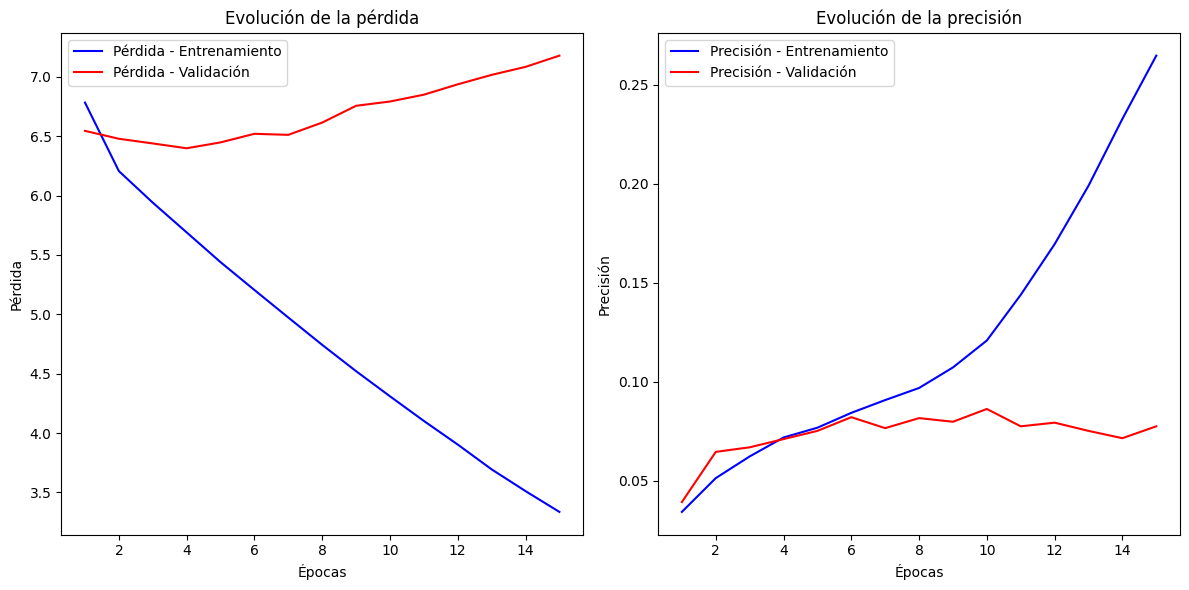

In [ ]:
import matplotlib.pyplot as plt

# Extraer las métricas del objeto history
history_dict = history_1.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

# Número de épocas
epochs = range(1, len(loss) + 1)

# Graficar la pérdida
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # Primera gráfica
plt.plot(epochs, loss, 'b', label='Pérdida - Entrenamiento')
plt.plot(epochs, val_loss, 'r', label='Pérdida - Validación')
plt.title('Evolución de la pérdida')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Graficar la precisión
plt.subplot(1, 2, 2)  # Segunda gráfica
plt.plot(epochs, accuracy, 'b', label='Precisión - Entrenamiento')
plt.plot(epochs, val_accuracy, 'r', label='Precisión - Validación')
plt.title('Evolución de la precisión')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

plt.tight_layout()
plt.show()


### Análisis del gráfico:
En el gráfico se observa aún existe el mismo problema de que la pérdida de validación tiene pendiente positiva (aumenta) y no así la de entrenamiento, sigue manifestando un sobreajuste. En cuanto a la precisión, apenas aceptable en el entrenamiento y muy baja en la validación (ademas de parecer estabilizarse en ese valor bajo).
Se me ocurre que el problema puede estar en el conjunto de datos de entrenamiento, que no sea suficiente ese solo libro para detectar patrones y generear un texto con el mismo estilo (en ese caso debería buscar bibliografía similar y adjuntarla a los datos de entrenamiento).


### ACLARACIÓN:
Me quedó pendiente subir al cuaderno la prueba con la búsqueda de los mejores hiperparámetros con GridSearch porque aún no me termina de ejecutar.. La subiré cuando termine para estar seguro de que se completa la ejecución

### MATERIAL DE CONSULTA:

- Bibliografía de la cátedra "Procesamienteo del habla" a cargo de la Ing. Ana DIedrich.
- ¿Qué es una red LSTM? - https://www.youtube.com/watch?v=1BubAvTVBYs
- Canal de Youtube "Codificando Bits" - https://www.youtube.com/@codificandobits
- GENERACIÓN DE TEXTO con Redes Recurrentes en Python (Tutorial) - https://www.youtube.com/watch?v=aA9QaPu_QpA
- Promps en ChatGPT:
   - Consideraciones a tener en cuenta al momento de entrenar modelos de generación de texto con redes recurrentes.
   - ¿si es que no puedo aumentar el tamaño del corpus, cuales son los parámetros que puedo modificar para mejorar la accuracy del modelo?
   - ¿Como puedo mejorar el entrenamiento del modelo para que en la generación de texto dejen de aparecer palabras repetidas de manera constante?
   - ¿Porque a pesar de variar los parámetros que disponibles para el ajuste del modelo no logro mejorar significativamente su desempeño? ¿Existen otras variables que le afecten?